### Mike's Exploration of the ADH data...

This builds off of Spencer's replication. It cuts the data in a way that we can plot and understand what is going on...

In [7]:
from  IPython.display  import display, Image # Displays things nicely
import pandas as pd
from pandas_datareader import data, wb # This will import the data reader

import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from linearmodels.iv import IV2SLS

#fig_path = "C:\\Users\\mwaugh.NYC-STERN\\Documents\\GitHub\\tradeexposure\\figures"
# This is if I want to output the figure

---

## Aggregate Facts

This section will focus on essentially three issues:

- **Expansion of Chinese Trade** and what we show is that essentially **all** of US trade growth since the 1990s is from the expansion of Chinese imports.


- **Fall in Real Interest Rates** Around the time the Chinese trade expanded, real interest rates fell quite dramatically. This is related to Bernanke's "Global Savings Glut" hypothesis. Expositied [here](https://www.federalreserve.gov/boarddocs/speeches/2005/200503102/)


- **Expansion of the Trade Deficit** during this time period. Need to explore.

In [74]:
codes = ["GDP", "IMPGS", "EXPGS", "IMPCH", "GS1", "CPILFESL"] 
# nomial gdp, imports, imports from china, constant maturity 1 year rate, cip (no energy or food)

fred = data.DataReader(codes,"fred",1990)  # Then for fred, you hand it the codes
                                            # Tell it you want to ask from FRED
                                            # then tell it the start date

In [75]:
display(fred.head(10))
#fred.dropna(inplace = True)

,GDP,IMPGS,EXPGS,IMPCH,GS1,CPILFESL
DATE,,,,,,
1990-01-01,5890.835,626.767,538.235,1186.1,7.92,132.1
1990-02-01,NaN,NaN,NaN,993.8,8.11,132.7
1990-03-01,NaN,NaN,NaN,931.0,8.35,133.5
1990-04-01,5974.665,614.759,545.926,996.4,8.40,134.0
1990-05-01,NaN,NaN,NaN,1173.5,8.32,134.4
1990-06-01,NaN,NaN,NaN,1317.2,8.10,135.1
1990-07-01,6029.504,630.102,555.149,1492.5,7.94,135.8
1990-08-01,NaN,NaN,NaN,1568.6,7.78,136.6
1990-09-01,NaN,NaN,NaN,1432.1,7.76,137.1


### Fact \#1:  Growth in Chines Imports Accounts for Aggregate Import Growth

First we need to get things to quarterly frequency with the china stuff...

In [10]:
china_imports = pd.DataFrame(fred["IMPCH"].resample("Q", convention= 'end').sum())

china_imports.index = china_imports.index + pd.DateOffset(days=1)

china_imports.head()

china_imports.rename(columns = {"IMPCH": "ch_imports"}, inplace = True)

trade = fred.merge(china_imports, how = "outer", left_index = True, right_index = True)

trade = trade.resample("Y", convention= 'end').sum()

trade["imports_gdp"] =  100* (trade.IMPGS / trade.GDP )

trade["ch_imports"] = 0.01*trade["ch_imports"] 

trade["frac_china"] = 100.*trade["ch_imports"] / trade["IMPGS"]

trade["china_share"] = 100.*trade["ch_imports"] / trade["GDP"]

In [11]:
trade.loc["2018-12-31"]

trade.drop(pd.to_datetime("2018-12-31"), inplace = True)

trade.head()

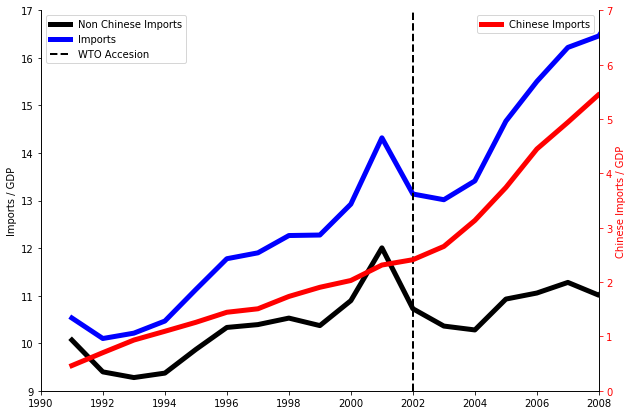

In [98]:
fig, ax = plt.subplots(figsize = (10,7))


ax.plot(trade["imports_gdp"]-trade["china_share"], color = "black",
        linewidth = 5, label = "Non Chinese Imports")

ax.plot(trade["imports_gdp"], color = "blue",
        linewidth = 5, label = "Imports")

ax1 = ax.twinx()

ax1.plot(trade["china_share"], color = "red", lw = 5,
        label = "Chinese Imports")

ax1.set_ylabel('Chinese Imports / GDP', color='r')
ax1.tick_params('y', colors='r')

ax.spines["top"].set_visible(False)
ax1.spines["top"].set_visible(False)


ax.set_ylabel("Imports / GDP") 

ax.set_xlim("1990-01-01", "2008-01-01")

ax.axvline(x= "2002-01-01",           # Set the value equall to the average
           color='k',       # make the color red
           label='WTO Accesion', # this is the label (shows up in the legend)
           linestyle='--',   # the line style
           linewidth=2)     # thickness of the line

ax.set_ylim(9,17)
ax1.set_ylim(0,7)

ax.legend()
ax1.legend()

plt.legend()

plt.show()

### Fact \#2 400 basis point fall in real Interest rates leading into China Expansion

In [60]:
irates = pd.DataFrame(fred["GS1"].resample("Q", convention= 'end').mean())

irates.index = irates.index + pd.DateOffset(days=1)

irates.head()

####################3

inflation = pd.DataFrame(fred["CPILFESL"].resample("Q", convention= 'end').mean())

inflation.index = inflation.index + pd.DateOffset(days=1)

irates["real"] = irates["GS1"] - 100*inflation["CPILFESL"].pct_change(4)

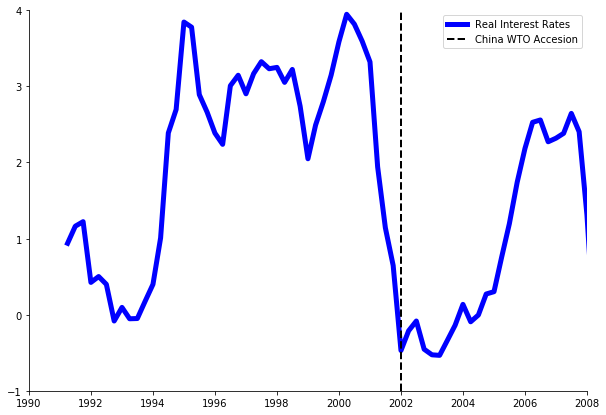

In [100]:
fig, ax = plt.subplots(figsize = (10,7))

ax.plot(irates.real, color = "blue", lw = 5,
        label = "Real Interest Rates")

ax.set_xlim("1990-01-01", "2008-01-01")
ax.set_ylim(-1, 4)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.axvline(x= "2002-01-01",           # Set the value equall to the average
           color='k',       # make the color red
           label='China WTO Accesion', # this is the label (shows up in the legend)
           linestyle='--',   # the line style
           linewidth=2)     # thickness of the line

#ax1 = ax.twinx()

#ax1.plot(trade["china_share"], color = "red", lw = 5,
#        label = "Chinese Imports")

plt.legend()

plt.show()

### Fact #3 Expanding Trade Deficit

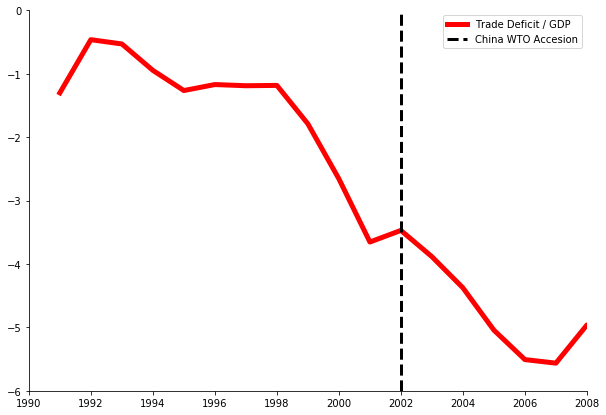

In [101]:
trade["trade_deficit"] = 100*(fred["EXPGS"] - fred["IMPGS"]).resample("Y", convention= 'end').sum()

trade["trade_deficit"] = trade["trade_deficit"]/trade["GDP"]

fig, ax = plt.subplots(figsize = (10,7))

ax.plot(trade.trade_deficit, color = "red", lw = 5,
        label = "Trade Deficit / GDP")

ax.set_xlim("1990-01-01", "2008-01-01")
ax.set_ylim(-6, 0)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.axvline(x= "2002-01-01",           # Set the value equall to the average
           color='k',       # make the color red
           label='China WTO Accesion', # this is the label (shows up in the legend)
           linestyle='--',   # the line style
           linewidth=3)     # thickness of the line

plt.legend()

plt.show()

---

## Micro Facts: ADH Evidence

Below I discuss three key facts that we want our model to replicate from the ADH evidence.

 - **Houshold Income** in Table 9 they have changes in houshold income per adult and then broken down by income type. The closest analog to what is in out model is "wage and salary" income variable. This is the one we will focus on. Its name in the ADH data set is: ``relchg_avg_hhincwage_pc_pw`` The key result is that a one standard deviation increase in the change in IPW results in a -5 percent reduction in wage growth.
 
- **Labor Supply** TBD


- **Migration** TBD

### Some Housecleaning of the ADH dataset

We will read in the dataset, create an excel sheet of the variable names, grab the region dummies, and then normalize the IPW measure. This last step is important to map the model to the data.

In [191]:
df = pd.read_stata("workfile_china.dta")
df["const"] = 1

var_names  = pd.DataFrame(df.columns)

var_names.to_excel("var_names.xlsx") # If you want to see what they are (like 200) this 
                                     # this is one way to do it...

regions = list(filter(lambda x: x.startswith("reg"), df.columns))
                                    # Spencer's way to figure out regional dummies.
    
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"] # This grabs the main RHS varibles used in the ADH regressions

df["norm_IPW"] = (df.d_tradeusch_pw - df.d_tradeusch_pw.mean()) /df.d_tradeusch_pw.std() 
                 # Take off the mean, divide by the statndard devition. So the value +1 means that value is one standard 
                 # deviation from the mean
    
display(df.norm_IPW.describe())

count    1.444000e+03
mean    -1.122948e-15
std      1.000000e+00
min     -9.812393e-01
25%     -5.697243e-01
50%     -2.812850e-01
75%      2.248966e-01
max      1.594217e+01
Name: norm_IPW, dtype: float64

#### Summary statistics about trade exposure. 

The first one reports the mean change in trade exposure.

In [215]:
years  = [1990, 2000]
sum_stats_dm = []
sum_stats = []

for var in years:

    sum_stats.append(round(df.set_index("yr").loc[var].d_tradeusch_pw.median(),2))   
    
print("Change in Import Exposure ($)", sum_stats)

print("Average Level of Trade Per Worker (thousands)", round(df.set_index("yr").loc[1990].l_tradeusch_pw.mean(),2))

print("Average Level of Trade Per Worker (thousands)", round(df.set_index("yr").loc[2000].l_tradeusch_pw.mean(),2))

print("Average Level of Trade Per Worker (thousands)", round(df.set_index("yr").loc[1990
                                                                                   ].l_avg_hhincwage_pc_pw.median(),2))

print("Average Level of Trade Per Worker (thousands)", round(df.set_index("yr").loc[2000
                                                                                   ].l_avg_hhincwage_pc_pw.median(),2))

print("Average Level of Trade Per Worker (thousands)", round(df.set_index("yr").loc[1990
                                                                                   ].relchg_avg_hhincwage_pc_pw.mean(),2))

df.set_index("yr").relchg_avg_hhincwage_pc_pw.describe()

Change in Import Exposure ($) [0.75, 1.94]
Average Level of Trade Per Worker (thousands) 0.36
Average Level of Trade Per Worker (thousands) 1.12
Average Level of Trade Per Worker (thousands) 17380.03
Average Level of Trade Per Worker (thousands) 20936.73
Average Level of Trade Per Worker (thousands) 20.55


count    1444.000000
mean       12.934160
std        12.624860
min       -20.783587
25%         3.509753
50%        12.910077
75%        21.358577
max        63.671665
Name: relchg_avg_hhincwage_pc_pw, dtype: float64

So what this means is in the first period, trade exposure grew by about 750 dollars. Then in the second period, trade exposure grew by almost 2000 dollars. This large change is quite dramatic and we will see more about this second period vs. the third period below. 

One question is about the levels. So the mean level of trade exposure was 360 dollars in 1990. Small. The final piece of output constructs the change from the levels to ensure that it is matching up with the change above. It appears to be in the same ball park.

---
### Household Wage Income Results...

I first want to plot this and cut it by the time period. ADH main results stack two time periods 90s and 2000s. The 2000s correspond with the big rise in Chinese trade; the 1990s is far less dramatic. 

#### The plot test

Lets simply plot the change in IPW vs. the percent change in household "wage and salary" income per adult.

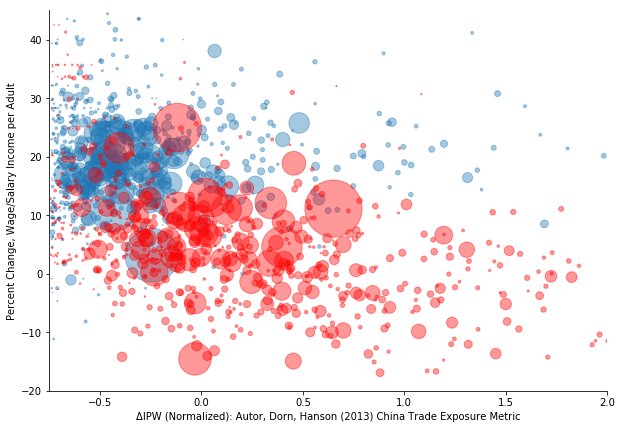

In [173]:
fig, ax = plt.subplots(figsize = (10,7))

year = "1990"

#df["norm_IPW"]

ax.scatter(df.set_index("yr").loc[int(year)].norm_IPW, #X variables
           df.set_index("yr").loc[int(year)].relchg_avg_hhincwage_pc_pw,     # y variables 
            s = 0.0002*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40) 

year = "2000"

ax.scatter(df.set_index("yr").loc[int(year)].norm_IPW, #X variables
           df.set_index("yr").loc[int(year)].relchg_avg_hhincwage_pc_pw,     # y variables 
           s = 0.0002*df.set_index("yr").loc[int(year)].l_popcount,
            alpha = 0.40, color = "red") 

ax.set_ylabel("Percent Change, Wage/Salary Income per Adult") 
ax.set_xlabel("ΔIPW (Normalized): Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-0.75,2.00)
ax.set_ylim(-20,45)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\adh_data_wage_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

This is quite interesting. What do I see:

- First you see how there is far more variation in trade exposure for the 2000s (red) periods vs. the 90s (blue). China came in and **fundamentally altered a commute zones exposure to trade by large amounts** 


- If you eye-ball this enough, for the 90s, **there is essentially zero correlation between income growth and trade exposure during this time period.** If anything, it is slightly positive.


- If you look at the 2000s (red), two things are going on. First, wage growth is lower overall (shorter time period?) Second, there is **MAYBE** a "hockey stick" pattern between wage growth and trade exposure.


- Finally, a better characterization of the data is this (i) in 1990's, there is no relationship and (ii) in the 2000's the average growth rate of wages fell, but variance when up a bunch (and there is no relatioship wither within the 2000's). But what we have is two clusters: the 1990s with low exposure, high wages and then another cluster with high exposure, low wages. Then you get a negative slope? 

- NOTE there is some issue about the interpertation of the percent change, since their are different years. Claim is that this is always converted to 10 year changes?

#### Now this is the specification that will replicate Table 9 in ADH

In [200]:
###############################################################################
# Then this does the specification that will replicate ADH...
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"]

rhs_var.append("t2")

reg_df = df
    
res_first = IV2SLS(reg_df.relchg_avg_hhincwage_pc_pw, 
                   reg_df[["const"]+ rhs_var + regions],
                   reg_df.d_tradeusch_pw, 
                   reg_df.d_tradeotch_pw_lag,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

                              IV-2SLS Estimation Summary                              
Dep. Variable:     relchg_avg_hhincwage_pc_pw   R-squared:                      0.4278
Estimator:                            IV-2SLS   Adj. R-squared:                 0.4214
No. Observations:                        1444   F-statistic:                    735.75
Date:                        Fri, May 18 2018   P-value (F-stat)                0.0000
Time:                                15:57:59   Distribution:                 chi2(16)
Cov. Estimator:                     clustered                                         
                                                                                      
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 60.679     8.9966     6.

So the results ``-2.1416 (0.5851)`` exactly matches up with the ADH coeffecient estimate. Now below I will do it with a normalization.  

In [211]:
res_first = IV2SLS(reg_df.relchg_avg_hhincwage_pc_pw, 
                   reg_df[["const"]+ rhs_var + regions],
                   reg_df.norm_IPW, 
                   reg_df.d_tradeotch_pw_lag,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

                              IV-2SLS Estimation Summary                              
Dep. Variable:     relchg_avg_hhincwage_pc_pw   R-squared:                      0.4278
Estimator:                            IV-2SLS   Adj. R-squared:                 0.4214
No. Observations:                        1444   F-statistic:                    735.75
Date:                        Fri, May 18 2018   P-value (F-stat)                0.0000
Time:                                16:08:50   Distribution:                 chi2(16)
Cov. Estimator:                     clustered                                         
                                                                                      
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 56.598     8.4798     6.

Which says that a **one standard deviation increase in the change in IPW** results in a **-5 percent** reduction in wage growth. 

In [219]:
reg_df = df

rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"]

rhs_var.append("t2")

res_first = IV2SLS(reg_df.relchg_avg_hhincwage_pc_pw, 
                   reg_df[["const"]+ rhs_var + regions + ["norm_IPW"]],
                   None, 
                   None,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

                                OLS Estimation Summary                                
Dep. Variable:     relchg_avg_hhincwage_pc_pw   R-squared:                      0.4786
Estimator:                                OLS   Adj. R-squared:                 0.4728
No. Observations:                        1444   F-statistic:                    746.16
Date:                        Fri, May 18 2018   P-value (F-stat)                0.0000
Time:                                16:40:36   Distribution:                 chi2(16)
Cov. Estimator:                     clustered                                         
                                                                                      
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 59.387     8.9524     6.

In [196]:
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource"]

###############################################################################
# this does it by decade...

year = [1990, 2000]

wage_elas = []

for item in year:
    
    reg_df = df.set_index("yr").loc[item]
    
    res_first = IV2SLS(reg_df.relchg_avg_hhincwage_pc_pw, 
                   reg_df[["const"]+ rhs_var + regions],
                   reg_df.d_tradeusch_pw, 
                   reg_df.d_tradeotch_pw_lag,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])
    
    wage_elas.append(res_first.params.d_tradeusch_pw)

###############################################################################
# Then this does the specification that will replicate ADH...

rhs_var.append("t2")

reg_df = df
    
res_first = IV2SLS(reg_df.relchg_avg_hhincwage_pc_pw, 
                   reg_df[["const"]+ rhs_var + regions],
                   reg_df.d_tradeusch_pw, 
                   reg_df.d_tradeotch_pw_lag,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])


print(res_first)
print("Indivitual time periods 1990, then 2000   ", wage_elas)
#print("ADH result (stacked time periods)   ", res_first.params.norm_IPW)


                              IV-2SLS Estimation Summary                              
Dep. Variable:     relchg_avg_hhincwage_pc_pw   R-squared:                      0.4278
Estimator:                            IV-2SLS   Adj. R-squared:                 0.4214
No. Observations:                        1444   F-statistic:                    735.75
Date:                        Fri, May 18 2018   P-value (F-stat)                0.0000
Time:                                15:57:00   Distribution:                 chi2(16)
Cov. Estimator:                     clustered                                         
                                                                                      
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 60.679     8.9966     6.

This kind of confirms what is going on the figure above...two regions, one with high wage growth, low trade exposure. The other with low wage growth, high trade exposure. Within each region, there is an unclear relationship (1990s, positive insignificant), the (2000s, negative, insignificant). But then with the two together, it becomes strikingly negative and significant. 

One final point about this. The stuff below shows that essentially a time effect + region effect explains all the variation in wages, very little room for other things. 

In [217]:
rhs_var = []

rhs_var.append("t2")

res_first = IV2SLS(reg_df.relchg_avg_hhincwage_pc_pw, 
                   reg_df[["const"]+ rhs_var + regions + ["norm_IPW"]],
                   None, 
                   None,
                   weights = reg_df["timepwt48"]).fit(cov_type="clustered", clusters=reg_df["statefip"])

print(res_first)

ValueError: regressors [exog endog] do not have full column rank

---

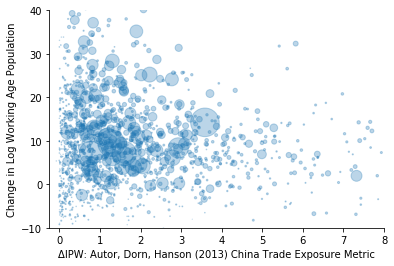

In [42]:
fig, ax = plt.subplots()

ax.scatter(df.d_tradeusch_pw, df.lnchg_popworkage,     # x,y variables 
            s = 0.00005*df.l_popcount,
            alpha = 0.30) # Then this last command specifies how dark or light the bubbles are...

#ax.set_title("Trade Exposure and Wage Growth")
ax.set_ylabel("Change in Log Working Age Population") 
ax.set_xlabel("ΔIPW: Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-10,40)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig(fig_path + "\\adh_data_pop_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

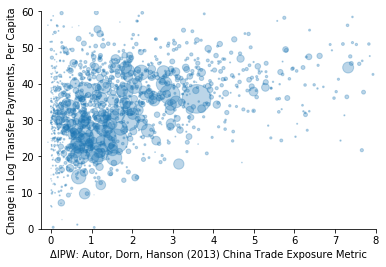

In [43]:
fig, ax = plt.subplots()

ax.scatter(df.d_tradeusch_pw, df.lnchg_trans_totindiv_pc,     # x,y variables 
            s = 0.00005*df.l_popcount,
            alpha = 0.30) # Then this last command specifies how dark or light the bubbles are...

#ax.set_title("Trade Exposure and Wage Growth")
ax.set_ylabel("Change in Log Transfer Payments, Per Capita") 
ax.set_xlabel("ΔIPW: Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-0,60)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig(fig_path + "\\adh_data_trans_change.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

**This is the Houshold income measure**

In [ ]:
fig_path = "C:\\Users\\mwaugh.NYC-STERN\\Documents\\GitHub\\tradeexposure\\figures"

fig, ax = plt.subplots()

ax.scatter(df.d_tradeusch_pw, relchg_avg_hhincsum_pc_pw,     # x,y variables 
            s = 0.00005*df.l_popcount,
            alpha = 0.30) # Then this last command specifies how dark or light the bubbles are...

#ax.set_title("Trade Exposure and Wage Growth")
ax.set_ylabel("Log Change in Average Weekly Wages") 
ax.set_xlabel("IPW: Autor, Dorn, Hanson (2013) China Trade Exposure Metric")

ax.set_xlim(-.25,8)
ax.set_ylim(-20,35)

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

#plt.savefig(fig_path + "\\adh_data.pdf", bbox_inches="tight", dpi = 1200)

plt.show()

In [46]:
rhs_var = ["l_shind_manuf_cbp",
    "l_sh_popedu_c",
    "l_sh_popfborn",
    "l_sh_empl_f",
    "l_sh_routine33",
    "l_task_outsource", "t2"]


res_first = IV2SLS(df.lnchg_popworkage, df[["const"] + rhs_var+ regions+ ["d_tradeusch_pw"]], 
                   None, None, 
                   weights = df["timepwt48"]).fit(cov_type='unadjusted')

print(res_first)

                            OLS Estimation Summary                            
Dep. Variable:       lnchg_popworkage   R-squared:                      0.4250
Estimator:                        OLS   Adj. R-squared:                 0.4185
No. Observations:                1444   F-statistic:                    1067.3
Date:                Thu, Mar 15 2018   P-value (F-stat)                0.0000
Time:                        14:16:15   Distribution:                 chi2(16)
Cov. Estimator:            unadjusted                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 1.1659     5.4564     0.2137     0.8308     -9.5284      11.860
l_shind_manuf_cbp    -0.

In [28]:
res_first = IV2SLS(df.lnchg_popworkage, df[["const"]+ rhs_var + regions], 
                   df.d_tradeusch_pw, df.d_tradeotch_pw_lag, 
                   weights = df["timepwt48"]).fit(cov_type='unadjusted')

print(res_first)

                          IV-2SLS Estimation Summary                          
Dep. Variable:       lnchg_popworkage   R-squared:                      0.4234
Estimator:                    IV-2SLS   Adj. R-squared:                 0.4169
No. Observations:                1444   F-statistic:                    1061.5
Date:                Sat, Mar 10 2018   P-value (F-stat)                0.0000
Time:                        08:48:41   Distribution:                 chi2(16)
Cov. Estimator:            unadjusted                                         
                                                                              
                                 Parameter Estimates                                 
                   Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-------------------------------------------------------------------------------------
const                 1.2356     5.4644     0.2261     0.8211     -9.4745      11.946
l_shind_manuf_cbp    -0.

In [16]:
just1990 = df.set_index("yr").loc[1990]

res_first = IV2SLS(just1990.d_avg_lnwkwage, 
                   just1990[["const"]], 
                   just1990.dm_IPW, just1990.d_tradeotch_pw_lag,
                   weights = just1990["timepwt48"]).fit(cov_type='unadjusted')

print(res_first)

                          IV-2SLS Estimation Summary                          
Dep. Variable:         d_avg_lnwkwage   R-squared:                      0.0008
Estimator:                    IV-2SLS   Adj. R-squared:                -0.0006
No. Observations:                 722   F-statistic:                    0.0063
Date:                Thu, Mar 01 2018   P-value (F-stat)                0.9370
Time:                        16:17:57   Distribution:                  chi2(1)
Cov. Estimator:            unadjusted                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          11.866     0.3043     38.987     0.0000      11.269      12.462
dm_IPW         0.0136     0.1717     0.0791     0.93